In [14]:
import numpy as np
import pandas as pd
import os 
import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib
from utils import *
from joblib import Parallel, delayed
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

## Settings and parameters

In [8]:
benchmarks = {"transcode": "cats-1", "pigo-faceblur": "faces2", "pigo-face-detector": "faces2", "linpack": "2500", "s3": "cats-1", "openfaas-ocr": "doc"}
# benchmarks ={"transcode": "cats-1"}
# base_estimators = ['GP', 'GBRT', 'ET', 'RF', 'poly']

# sampling_techniques = ["random", "fixed", "variable", "lhs"]
# sampling_techniques = ["random", "lhs", "model"]
sampling_techniques = ["model"]
# sampling_techniques = ["all"]

CPU_LIMITS= [ '250m', '500m', '750m', '1000m', '1250m', '1500m', '1750m', '2000m' ]
MEMORY_LIMITS=[ '128Mi', '256Mi', '512Mi', '768Mi', '1024Mi', '2048Mi' ]
instance_types = ['m5', 'm5a', 'c5', 'c5a', 'c6g', 'm6g']

benchmark_naming = {"transcode": "transcode", "pigo-faceblur": "faceblur", "pigo-face-detector": "facedetect", "classifier": "classifier", "linpack": "linpack", "s3": "s3", "openfaas-ocr": "ocr"}

# Weights (runtime_weight, cost_weight)
weights =[(0.0, 1.0), (0.25, 0.75), (0.50, 0.50), (0.75, 0.25), (1.0, 0.0)]
# weights = [(0.75, 0.25)]

N_TRAILS = 40
N_INIT_SAMPLES = 20
N_OPT_TRAILS = 10

data_dir = 'analysis_data/'

calculate_cpu_mem_costs()

## Helper functions

In [9]:
def get_individual_error_across_all_configs(model, function_name, errors_violin, x, sampling_technique, metric='runtime', take_abs = True):
    model_all_predictions = model.get_all_config_predictions(function_name)
    # print(model_top_k)

    actual_performance = []
    for i in range(0, len(model_all_predictions)):
        conf = model_all_predictions[i][1]
        config = {'instance_type': conf[0], 'cpu': conf[1], 'memory': conf[2]}
        result = get_result_from_data(function_name, data_name, config, MEMORY_LIMITS, metric=metric)
        actual_performance.append((result, conf))

    mape = 0.0
    for i in range(0, len(model_all_predictions)):
        if take_abs:
            mape = 100*abs(model_all_predictions[i][0]-actual_performance[i][0])/actual_performance[i][0]
        else:
            mape = 100*(model_all_predictions[i][0]-actual_performance[i][0])/actual_performance[i][0]
        errors_violin = errors_violin.append({'benchmark': function_name, 'trials': x, 'mape': mape, 'sampling': sampling_technique}, ignore_index=True)
    
    # mae = 100*mae/float(len(model_all_predictions))

    return errors_violin

In [10]:
def error_across_all_configs(model, function_name, metric='runtime'):
    model_all_predictions = model.get_all_config_predictions(function_name)
    # print(model_top_k)

    actual_performance = []
    for i in range(0, len(model_all_predictions)):
        conf = model_all_predictions[i][1]
        config = {'instance_type': conf[0], 'cpu': conf[1], 'memory': conf[2]}
        result = get_result_from_data(function_name, data_name, config, MEMORY_LIMITS, metric=metric)
        actual_performance.append((result, conf))

    mae = 0.0
    for i in range(0, len(model_all_predictions)):
        e = abs(model_all_predictions[i][0]-actual_performance[i][0])/actual_performance[i][0]
        # if e*100 > 50.0:
        #     print(actual_performance[i][0], model_all_predictions[i])
        mae += e
    
    mae = 100*mae/float(len(model_all_predictions))

    return mae

In [11]:
def error_across_top_per_types(model, function_name, marker='all', metric='runtime'):
    model_top_per_type = model.get_top_across_types(function_name)
    # print(model_top_k)

    k = len(instance_types)

    actual_model_top_per_type = []
    for i in range(0, k):
        conf = model_top_per_type[i][1]
        config = {'instance_type': conf[0], 'cpu': conf[1], 'memory': conf[2]}
        result = get_result_from_data(function_name, data_name, config, MEMORY_LIMITS, metric=metric)
        actual_model_top_per_type.append((result, conf))
    # print(actual_model_top_k)

    data_top_per_type = get_top_per_type_configs_from_data(instance_types, CPU_LIMITS, MEMORY_LIMITS, function_name, data_name, metric=metric)
    # print(data_top_per_type)
    # print(model_top_per_type)

    mae = 0.0
    for i in range(0, k):
        # print(data_top_per_type[i][0], actual_model_top_per_type[i][0])
        # The reason why we don't use the actual performance of the configuration suggested by the model is that the decisions are going
        # To be made on the prediction not the actual runtime until the configuration has been executed
        mae += abs(model_top_per_type[i][0]-data_top_per_type[i][0])/data_top_per_type[i][0]
    
    mae = 100*mae/float(k)

    return mae

# Weighted Multi-objective Optimization
Performance weighted multi-objective optimization

**Note: This is a long running process (with the runtime in the order of 10s of minutes) and can utilize multiple cores in compute intensive tasks**

In [15]:
errors = pd.DataFrame(columns=['benchmark', 'trials', 'mape', 'sampling'])
errors_across_types = pd.DataFrame(columns=['benchmark', 'trials', 'mape', 'sampling'])
errors_violin = pd.DataFrame(columns=['benchmark', 'trials', 'mape', 'sampling'])

for function_name in benchmarks.keys():
    runtimes = pd.DataFrame(columns=['trials', 'runtime', 'cost', 'metric value', 'sampling', 'metric', 'config'])
    data_name = benchmarks[function_name]
    print(function_name)
    for x in range(0, N_OPT_TRAILS):
        base_estimator = "GP"
        
        for sampling_technique in sampling_techniques:
            min_value = {}
            print(sampling_technique)
            
            if sampling_technique == "random":
                N_INIT_SAMPLES = 20
                init_samples = get_random_samples(CPU_LIMITS, MEMORY_LIMITS, instance_types, seed=x, n_samples=N_INIT_SAMPLES)
            elif sampling_technique == "lhs":
                N_INIT_SAMPLES = 20
                init_samples = get_lhs_samples(CPU_LIMITS, MEMORY_LIMITS, instance_types, seed=x, n_samples=N_INIT_SAMPLES)
            elif sampling_technique == "model":
                N_INIT_SAMPLES = 3
                init_samples = get_random_samples(CPU_LIMITS, MEMORY_LIMITS, instance_types, seed=x, n_samples=N_INIT_SAMPLES)

            default_config = init_samples[0]
            config = default_config

            for metric in ['runtime', 'cost']:
                minimum = 600.0

                from optimizer.boskopt import Models
                model = Models()
                model.create_model(function=function_name, base_estimator=base_estimator, seed=x)


                for i in range(0, N_TRAILS):
                    success = True
                    result = get_result_from_data(function_name, data_name, config, MEMORY_LIMITS, metric=metric)
                    # print(result) 

                    if result < minimum:
                        minimum = result

                    model.update(config, result, function_name, success=True)
                    
                    if i < N_INIT_SAMPLES-1:
                        
                        config = init_samples[i+1]
                    else:
                        config = model.get_next_config(function_name)

                min_value[metric] = minimum

            for weight in weights:
                minimum  = 10000.0
                minimum_runtime = 10000.0
                minimum_cost = 10000.0
                min_config = ""

                from optimizer.boskopt import Models
                model = Models()
                model.create_model(function=function_name, base_estimator=base_estimator, seed=x)

                runtime_weight = weight[0]
                cost_weight = weight[1]

                for i in range(0, N_TRAILS):
                    success = True
                    runtime = get_result_from_data(function_name, data_name, config, MEMORY_LIMITS, metric='runtime')
                    norm_runtime = runtime/float(min_value['runtime'])
                    cost = get_result_from_data(function_name, data_name, config, MEMORY_LIMITS, metric='cost')
                    norm_cost = cost/float(min_value['cost'])
                    result = norm_runtime * runtime_weight + norm_cost * cost_weight
                    # print(result) 

                    if result < minimum:
                        minimum = result
                        minimum_runtime = runtime 
                        minimum_cost = cost 
                        min_config = config["instance_type"] + "_" + config["cpu"] + "_" + config["memory"]

                    if sampling_technique == "model":
                        model.update(config, result, function_name, success=True)
                    
                    if i < N_INIT_SAMPLES-1:
                        config = init_samples[i+1]
                    else:
                        config = model.get_next_config(function_name)

                    runtimes = runtimes.append({'trials': i, 'runtime': minimum_runtime, 'cost': minimum_cost, 'metric value': minimum, 'config': min_config, 'sampling': sampling_technique, 'metric': str(runtime_weight)+'/'+str(cost_weight)}, ignore_index=True)

    runtimes.to_csv(data_dir + 'metrics-'+function_name+'-40-bugfree.csv', index=False)

transcode
model
model
model
model
model
model
model
model
model
model
pigo-faceblur
model
model
model
model
model
model
model
model
model
model
pigo-face-detector
model
model
model
model
model
model
model
model
model
model
linpack
model
model
model
model
model
model
model
model
model
model
s3
model
model
model
model
model
model
model
model
model
model
openfaas-ocr
model
model
model
model
model
model
model
model
model
model


## Plot convergence graphs for weighted multi-objective optimization

(0.25, 0.75)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(0.5, 0.5)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(0.75, 0.25)


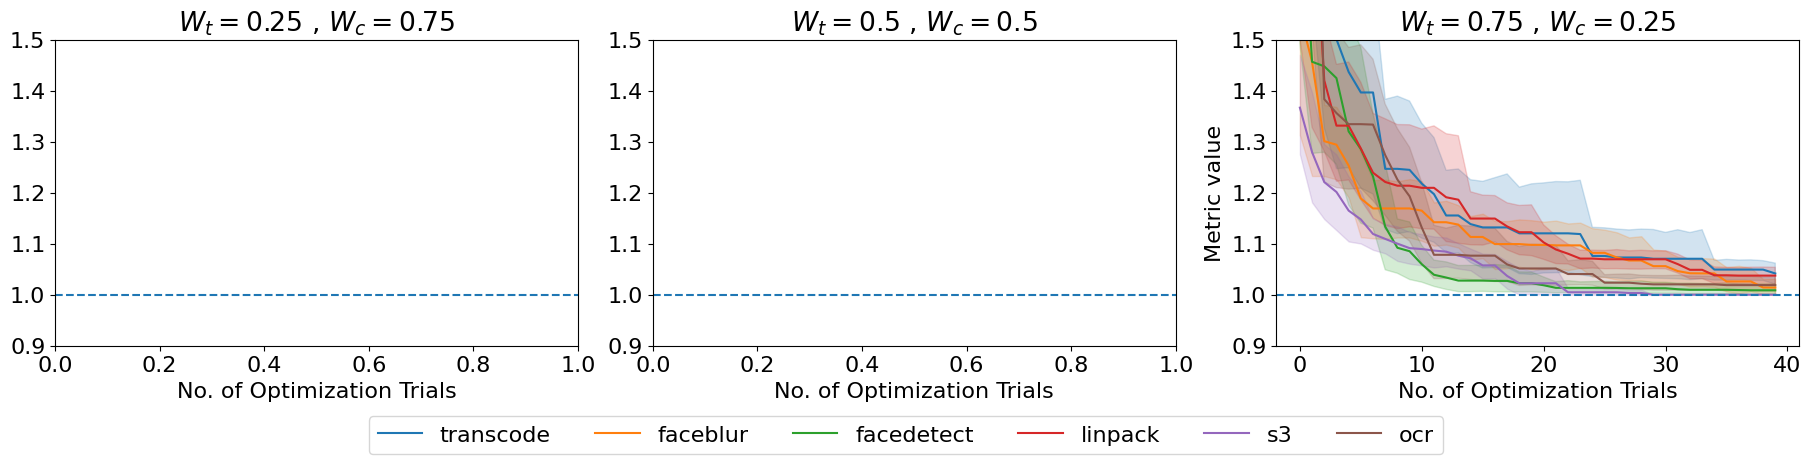

In [16]:
# Select the weights for the plots
# weights =[(0.0, 1.0), (0.25, 0.75), (0.50, 0.50), (0.75, 0.25), (1.0, 0.0)]
weights =[(0.25, 0.75), (0.50, 0.50), (0.75, 0.25)]

matplotlib.rcParams.update({'font.size': 16})
fig, axs = plt.subplots(figsize=(18, 4), ncols=len(weights), constrained_layout=True)
j = 0

for weight in weights:
    print(weight)
    runtime_weight = weight[0]
    cost_weight = weight[1]
    weighted_results = pd.DataFrame()

    for function_name in benchmarks.keys():
        # print(function_name)
        data_name = benchmarks[function_name]
        minimum_runtime, minimum_cost, _, _ = get_best_configuration(instance_types, CPU_LIMITS, MEMORY_LIMITS, function_name, data_name, metric=str(runtime_weight)+'/'+str(cost_weight))
        
        results = pd.read_csv(data_dir + 'metrics-' +function_name+ '-40-bugfree.csv')
        results = results[results['metric']==str(runtime_weight)+'/'+str(cost_weight)]
        results = results[results['sampling']=='model']
        

        results['Metric value'] =  ((results['runtime']/minimum_runtime) * runtime_weight) + ((results['cost']/minimum_cost) * cost_weight)
        results['Benchmark'] = [function_name] * len(results['Metric value'])

        weighted_results = weighted_results.append(results, ignore_index=True)

        # print(results)
    weighted_results.replace(benchmark_naming, inplace=True)
    ax = sns.lineplot(data=weighted_results, x='trials', y='Metric value', hue='Benchmark', ax=axs[j])
    ax.axhline(1.0, ls='--')
    # ax.text(0.5,minimum_runtime+10, "Minimum")
    # ax.set_xticks(np.arange(0, 22, 4))
    ax.set_xlabel('No. of Optimization Trials')
    # ax.set_xlim((0, 20))
    ax.set_ylim((0.9, 1.5))
    ax.set_title('$W_{t}=$'+str(runtime_weight)+' , '+'$W_{c}=$'+str(cost_weight))
        # plt.show()

    j+=1
    # if j != len(weights):
    ax.legend().set_visible(False)
# plt.legend(fontsize="small", ncol=2, loc='upper left')
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=6, bbox_to_anchor=(0.5, 0))
plt.savefig('weighted-mo-40-bugfree.pdf', bbox_inches = "tight")
